In [32]:
# TODO: Change Colab Link back to main and also remove Encoder and Decoder

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sascha-senko/TensorflowCourse/blob/HSinger04/ANNwTFHW7.ipynb)

## Imports

In [33]:
# TODO: Clean up imports
import matplotlib.pyplot as plt
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, \
    BatchNormalization, ELU, Flatten, Dense, ZeroPadding2D, AveragePooling2D, \
    Layer, GlobalAveragePooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.regularizers import L2
from functools import partial  
from tensorflow import debugging as debug

## Load dataset

In [34]:
(x_train, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = tf.data.Dataset.from_tensor_slices(x_train)
# take only first 1000 examples
x_test = tf.data.Dataset.from_tensor_slices(x_test).take(1000)

# Maps labels to object names
num_to_name = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

y_test = [num_to_name[y] for y in y_test]
# take only first 1000 examples
y_test = tf.data.Dataset.from_tensor_slices(y_test).take(1000)

## Inspect data set

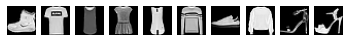

In [35]:
fig, ax = plt.subplots(1,10)

for i, img in enumerate(x_train):
    if i == 10:
        break
    ax[i].imshow(img, cmap='gray')
    ax[i].axis("off")

## Define some constants

In [36]:
# arbitrarily set. Feel free to change these
SHUFFLE_SIZE = x_test.cardinality()
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

## Prepare data

In [37]:
def process_inp(input):
    """ rescale and add channel dimension """
    # normalize between zero and one
    input = input / 255
    # add extra dimension for channel
    input = tf.expand_dims(input, -1)
    return input    



def data_pipeline(data, training):
    """ helper function for data pipeline - does all the things we need """
    
    data = data.map(process_inp)

    if training:
        data = data.shuffle(buffer_size=SHUFFLE_SIZE)

    data = data.batch(BATCH_SIZE)
    data = data.prefetch(PREFETCH_SIZE)
    return data

x_train = data_pipeline(x_train, True)
x_test = data_pipeline(x_test, False)

## Encoder

In [38]:
class Encoder(Model):
    # TODO: Implement init. If necessary, add additional arguments to init. 
    # Please use an output dimension of 10 for the final dense layer.
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(1, kernel_size=2, strides=(2, 2))
        self.conv2 = Conv2D(1, kernel_size=2, strides=(2, 2))
        self.flatten = Flatten()
        self.dense = Dense(10)

    # TODO: Implement call. If necessary, add additional arguments to call
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

### Check Encoder

In [39]:
test_inp = next(iter(x_train))
# TODO: @Sascha: Maybe you need to adjust the init arguments?
encoder = Encoder()
out = encoder(test_inp)
# Assert that shape of out is BATCH_SIZE, 10
debug.assert_equal(out.shape, tf.zeros((BATCH_SIZE, 10)).shape)

In [40]:
## Decoder

In [41]:
class Decoder(Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense = Dense(49)
        self.trans1 = Conv2DTranspose(1, kernel_size=2, strides=(2,2)) 
        self.trans2 = Conv2DTranspose(1, kernel_size=2, strides=(2,2))

    def call(self, x):
        # first, bring tensor back into shape before flattening in encoder
        x = self.dense(x)
        x = tf.reshape(x, (-1, 7, 7, 1))
        x = self.trans1(x)
        x = self.trans2(x)
        # TODO: In the homework, they suggested using convolution as well. Maybe implement?
        # sigmoid to get output in range 0 to 1
        x = tf.keras.activations.sigmoid(x)
        return x

### Check Decoder

In [42]:
test_inp = tf.random.uniform((BATCH_SIZE, 10))
# TODO: @Sarah: Maybe you need to adjust the init arguments?
decoder = Decoder()
out = decoder(test_inp)
# Assert that shape of out is BATCH_SIZE, 28, 28, 1
check_tensor = tf.zeros((BATCH_SIZE, 28, 28, 1))
# Check shape
debug.assert_equal(out.shape, check_tensor.shape)
# Check values between 0 and 1
debug.assert_greater_equal(out, check_tensor)
debug.assert_less_equal(out, check_tensor + 1)

## Autoencoder

In [43]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, x):    
        x = self.encoder(x)
        x = self.decoder(x)

        return x

    def embed(self, x):
        return self.encoder(x)

## Helper functions

In [44]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    test_loss_aggregator.append(sample_test_loss.numpy())

  test_loss = np.mean(test_loss_aggregator)

  return test_loss
  
  
  def plot_stats(train_stat, test_stat, stat_name):
    plt.figure()
    line1, = plt.plot(train_stat)
    line2, = plt.plot(test_stat)
    plt.xlabel("Training steps")
    plt.ylabel(stat_name)
    plt.legend((line1, line2), ("training", "test"))
    plt.show()

## Prepare for training

In [45]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001   
loss = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE)
TRAIN_STAT_DIM = (int(x_train.cardinality()))

# Collects embeddings of test set. 
# First dimension: Autoencoder vs VAE
# Second dimension: Embedding
EMBEDDINGS = {'Autoencoder': [], 'VAE': []}

# TODO: Define models
models = {'Autoencoder': Autoencoder()}

Epoch: 1


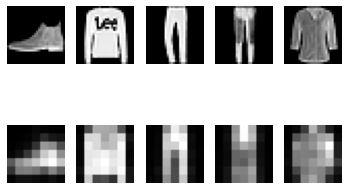

Epoch: 2


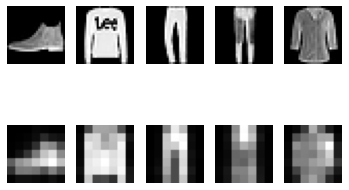

Epoch: 3


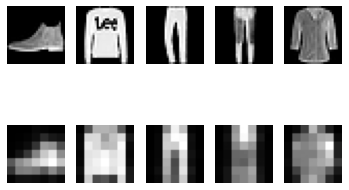

Epoch: 4


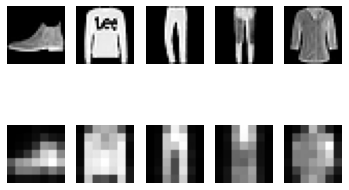

Epoch: 5


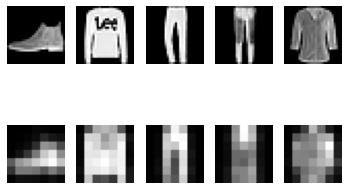

Epoch: 6


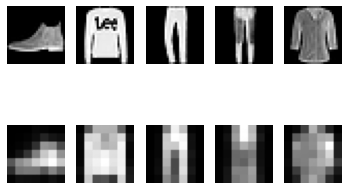

Epoch: 7


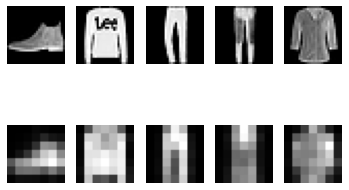

Epoch: 8


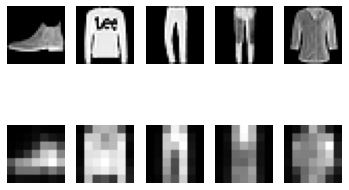

Epoch: 9


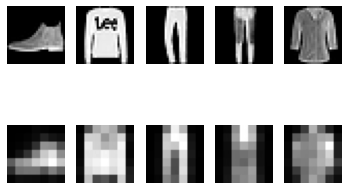

Epoch: 10


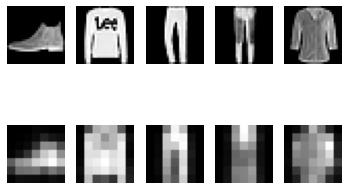

In [53]:
for model_name in models:

    model = models[model_name]

    # TODO: maybe change loss for different models
    # remove all active models for memory purposes
    tf.keras.backend.clear_session()


    # Initialize lists for later visualization.
    train_losses = []
    test_losses = []

    for epoch in range(NUM_EPOCHS):
        print('Epoch: ' + str(epoch+1))

        # shuffle train data. No need to shuffle test data. Since SHUFFLE_SIZE 
        # is bigger than number of batches we will shuffle the whole set
        x_train = x_train.shuffle(buffer_size=SHUFFLE_SIZE)

        train_loss_stat = np.empty(TRAIN_STAT_DIM)

        for i, input in enumerate(x_train):
            train_loss = train_step(model, input, input, loss, OPTIMIZER)
            train_loss_stat[i] = train_loss
        train_losses.append(np.mean(train_loss_stat))

        # testing
        test_loss = test(model, zip(x_test, x_test), loss)
        test_losses.append(test_loss)

        # plot some example images from test set with counter examples
        test_batch = next(iter(x_test))

        # squeeze is needed to change shape from (28, 28, 1) to (28, 28)
        recon_batch = tf.squeeze(model(test_batch))

        test_batch = tf.squeeze(test_batch)

        fig, ax = plt.subplots(2,5)

        for i in range (5):  
            ax[0, i].imshow(test_batch[i], cmap='gray')
            ax[1, i].imshow(recon_batch[i], cmap='gray')
            ax[0, i].axis("off")
            ax[1, i].axis("off")    

        plt.show()       
               

    # Get the embedding of the first 1000 images after training
    for test_batch in x_test:

        EMBEDDINGS[model_name].append(model.embed(test_batch))      

## Plotting

In [ ]:
from sklearn.manifold import TSNE

# Flatten the embedding list
np.array()

# TODO: remove acc